#### Proyecto Programación Avanzada: 
# Práctica 1, EDA eucaliptos en Cantabria

En esta práctica vamos a realizar un análisis exploratorio de datos para el género de eucaliptos, debido a que son una especie invasora en la península.

Primero, solucionamos el problema con la librería PROJ y GDAL

In [1]:
import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'

segundo, importamos los geodatos necesarios

In [2]:
import sys

sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\" #Ángel

euc_points = sys.argv[1] + "eucaliptos_españa_puntos\\eucalyptus_points.csv"
euc_mfe = sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp"


### 1.- Tratamiento de datos no espaciales

Ahora, vamos a empezar a tratar los datos, primero, hemos descargado de GBIF datos puntuales para toda España, vamos a tratarlos y luego los convertiremos en un geodato gracias a los datos de latitud y longitud.

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely

eucpoints_tabla = pd.read_table(euc_points)

C:\Users\angel\AppData\Local\Temp\ipykernel_7860\1555947320.py:7: DtypeWarning: Columns (10,14,16,17,29,39,40,41,43,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  eucpoints_tabla = pd.read_table(euc_points)


Esto nos indica que la tabla tiene "mixed types", por lo cual, da problemas. Vamos a solucionarlo

In [6]:
eucpoints_tabla = pd.read_table(euc_points, low_memory=False)
print(eucpoints_tabla.dtypes)

gbifID                                int64
datasetKey                           object
occurrenceID                         object
kingdom                              object
phylum                               object
class                                object
order                                object
family                               object
genus                                object
species                              object
infraspecificEpithet                 object
taxonRank                            object
scientificName                       object
verbatimScientificName               object
verbatimScientificNameAuthorship     object
countryCode                          object
locality                             object
stateProvince                        object
occurrenceStatus                     object
individualCount                     float64
publishingOrgKey                     object
decimalLatitude                     float64
decimalLongitude                

Aquellas con el tipo "object" son las que representan tipos mixtos que dan problema, vamos a ver cuáles nos hacen falta y cuales podemos eliminar

In [7]:
eucpoints_tabla = eucpoints_tabla.drop(columns=["datasetKey", "occurrenceID", "infraspecificEpithet",
                                             "taxonRank", "scientificName", "verbatimScientificName", 
                                             "verbatimScientificNameAuthorship", "publishingOrgKey", 
                                             "eventDate", "basisOfRecord", "institutionCode", "collectionCode", 
                                             "catalogNumber", "recordNumber", "identifiedBy", "dateIdentified", 
                                             "license", "rightsHolder", "recordedBy", "establishmentMeans", 
                                             "mediaType", "issue", "locality", "typeStatus", "stateProvince", 
                                                "occurrenceStatus", "gbifID", "kingdom", "phylum", "class", "order", 
                                               "countryCode", "individualCount", "family", "elevationAccuracy", "depth",
                                               "lastInterpreted", "taxonKey", "speciesKey", "coordinateUncertaintyInMeters", 
                                               "coordinatePrecision", "depthAccuracy", "day", "month", "year"], errors="ignore")
eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
0,Eucalyptus,NaN,NaN,NaN,NaN
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
...,...,...,...,...,...
178943,Eucalyptus,Eucalyptus reducta,NaN,NaN,NaN
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00
178946,Eucalyptus,Eucalyptus globulus,NaN,NaN,NaN


Ahora vamos a eliminar aquellas que tengan vacía algunas de las coordenadas vacías

In [8]:
eucpoints_tabla["decimalLatitude"] = eucpoints_tabla["decimalLatitude"].replace("", np.nan)
eucpoints_tabla["decimalLongitude"] = eucpoints_tabla["decimalLongitude"].replace("", np.nan)

eucpoints_tabla = eucpoints_tabla.dropna(subset=["decimalLatitude", "decimalLongitude"])

eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN
...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00


Lo siguiente, será transformarlo a geodato para poder extraer solo aquellos que se encuentran dentro del shapefile de Cantabria

In [12]:
from shapely.geometry import Point
from pyproj import CRS

eucpoints = eucpoints_tabla.copy()
eucpoints["geometry"] = eucpoints.apply(
    lambda row: Point(row["decimalLongitude"], row["decimalLatitude"]), axis=1
)
crs = CRS("EPSG:4326")
gdf = gpd.GeoDataFrame(eucpoints, geometry="geometry", crs=crs)

gdf.columns = [col[:10] for col in gdf.columns]

print(gdf.head())
gdf.set_crs("EPSG:4326", inplace=True)


        genus              species  decimalLat  decimalLon  elevation  \
1  Eucalyptus  Eucalyptus globulus   43.516539   -5.270636     157.00   
2  Eucalyptus  Eucalyptus globulus   42.567851   -8.873670      80.38   
3  Eucalyptus  Eucalyptus globulus   42.928194   -8.113348     489.00   
4  Eucalyptus  Eucalyptus globulus   42.889623   -8.571294     393.00   
5  Eucalyptus  Eucalyptus globulus   43.714230   -7.611280        NaN   

                    geometry  
1  POINT (-5.27064 43.51654)  
2  POINT (-8.87367 42.56785)  
3  POINT (-8.11335 42.92819)  
4  POINT (-8.57129 42.88962)  
5  POINT (-7.61128 43.71423)  


,genus,species,decimalLat,decimalLon,elevation,geometry
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00,POINT (-5.27064 43.51654)
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38,POINT (-8.87367 42.56785)
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00,POINT (-8.11335 42.92819)
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00,POINT (-8.57129 42.88962)
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN,POINT (-7.61128 43.71423)
...,...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00,POINT (-16.57865 28.11087)
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00,POINT (-16.58702 28.1176)
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00,POINT (2.7 39.78)
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00,POINT (2.7 39.77)


In [13]:
print(gdf.crs)  # Verificar que el sistema de coordenadas es correcto

EPSG:4326


In [14]:
gdf.to_file( sys.argv[1]+"eucpoints.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

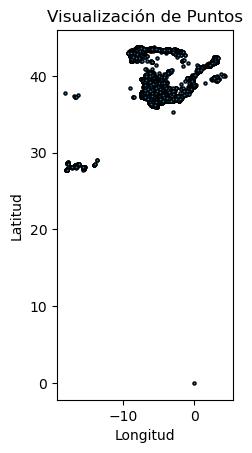

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import sys

# Cargar el shapefile
geodato_prueba = gpd.read_file(sys.argv[1] + "eucpoints.shp")


# Visualizar
geodato_prueba.plot(markersize=5, edgecolor="black")
plt.title("Visualización de Puntos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()



Ahora que lo hemos pasado a un archivo shapefile, vamos a extraer por la localización de cantabria concretamente.

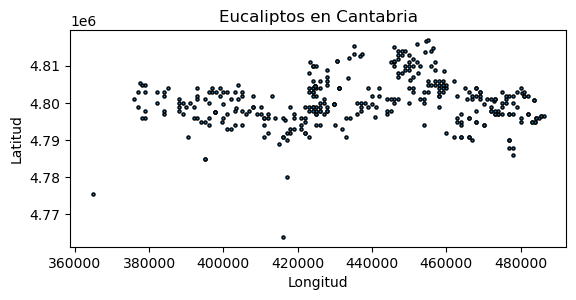

In [21]:
puntos_euc_españa = gpd.read_file(sys.argv[1] + "eucpoints.shp")
cantabria = gpd.read_file(sys.argv[1] + "cantabria_25830.shp")

# Verificar y transformar el CRS si es necesario
if cantabria.crs != "EPSG:25830":
    cantabria = cantabria.to_crs(epsg=25830)

# Convertir puntos_euc_españa a EPSG:25830
eucaliptos = puntos_euc_españa.to_crs(epsg=25830)

# Usar clip para obtener solo los puntos dentro de Cantabria
eucal_cant = gpd.clip(eucaliptos, cantabria)

# Graficar los puntos resultantes
eucal_cant.plot(markersize=5, edgecolor="black")
plt.title("Eucaliptos en Cantabria")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


y, como ha salido bien, vamos a guardar el geodato de eucaliptos de cantabria

In [23]:
eucal_cant.to_file(sys.argv[1]+"eucal_cant.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

print(eucal_cant.crs)

EPSG:25830


Volvemos a cargar los datos relevantes y cargamos también los datos de eucaliptos del mapa forestal

In [29]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
euc_mfe = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")
cantabria = gpd.read_file(sys.argv[1] + "cantabria_25830.shp")

In [30]:
eucal_cant

,genus,species,decimalLat,decimalLon,elevation,geometry
0,Eucalyptus,Eucalyptus globulus,43.118865,-4.661279,NaN,POINT (364851.922 4775354.135)
1,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
2,Eucalyptus,Eucalyptus globulus,43.208872,-4.291274,NaN,POINT (395107.05 4784819.375)
3,Eucalyptus,Eucalyptus globulus,43.262917,-4.350480,420.98,POINT (390394.463 4790897.316)
4,Eucalyptus,Eucalyptus globulus,43.290900,-4.281900,NaN,POINT (396008.177 4793917.334)
...,...,...,...,...,...,...
350,Eucalyptus,Eucalyptus globulus,43.484901,-3.539052,NaN,POINT (456409.81 4814805.63)
351,Eucalyptus,Eucalyptus globulus,43.485200,-3.667800,NaN,POINT (445998.906 4814914.295)
352,Eucalyptus,Eucalyptus globulus,43.494600,-3.593700,NaN,POINT (451998.399 4815912.846)
353,Eucalyptus,Eucalyptus globulus,43.501545,-3.561550,103.47,POINT (454602.986 4816666.108)
